In [1]:
import tensorflow as tf
import pandas as pd
import os

In [2]:
image_dir = "C:\\Users\\sejal\\Downloads\\diabetic_retinopathy\\colored_images"
csv_file = "C:\\Users\\sejal\\Downloads\\diabetic_retinopathy\\train.csv"

In [3]:
labels_df = pd.read_csv(csv_file)

In [4]:
label_map = dict(zip(labels_df['id_code'], labels_df['diagnosis']))

def get_filtered_file_paths(directory):
    class_folders = [os.path.join(directory, class_dir) for class_dir in os.listdir(directory) if not class_dir.startswith("._")]
    file_paths = []
    for folder in class_folders:
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if not file.startswith("._"):  # Excluding '._' files
                    file_paths.append(os.path.join(folder, file))
    return file_paths

filtered_file_paths = get_filtered_file_paths(image_dir)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
train_data = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
def clean_image_dir(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file.startswith("._"):
                os.remove(file_path)  
            else:
                try:
                    img = tf.io.read_file(file_path)
                    img = tf.image.decode_image(img)  
                except:
                    os.remove(file_path) 

clean_image_dir(image_dir)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


history = model.fit(train_data, validation_data=val_data, epochs=10)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Found 3662 files belonging to 5 classes.
Using 732 files for validation.
Epoch 1/10
92/92 [==============================] - 85s 905ms/step - loss: 55.5222 - accuracy: 0.6587 - val_loss: 0.8260 - val_accuracy: 0.7117
Epoch 2/10
92/92 [==============================] - 83s 898ms/step - loss: 0.7419 - accuracy: 0.7239 - val_loss: 0.7949 - val_accuracy: 0.7131
Epoch 3/10
92/92 [==============================] - 85s 923ms/step - loss: 0.7125 - accuracy: 0.7341 - val_loss: 0.8057 - val_accuracy: 0.7145
Epoch 4/10
92/92 [==============================] - 83s 900ms/step - loss: 0.6533 - accuracy: 0.7526 - val_loss: 0.8201 - val_accuracy: 0.7172
Epoch 5/10
92/92 [==============================] - 95s 1s/step - loss: 0.6126 - accuracy: 0.7700 - val_loss: 0.8386 - val_accuracy: 0.7240
Epoch 6/10
92/92 [==============================] - 86s 933ms/step - loss: 0.5681 - accuracy: 0.7884 - val_loss: 0.8278 - val_accuracy: 0.7295

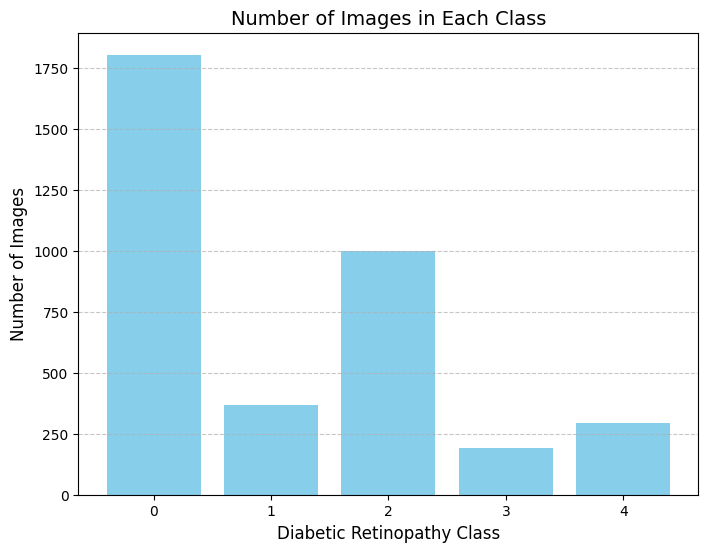

In [5]:
import matplotlib.pyplot as plt

class_counts = labels_df['diagnosis'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Diabetic Retinopathy Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images in Each Class', fontsize=14)
plt.xticks(class_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

val_data.reset()  
y_true = []
y_pred = []

for i in range(len(val_data)):
    x_batch, y_batch = val_data[i]
    predictions = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

class_labels = list(val_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)

print("Classification Report:")
print(report)